# Using MRS for Handwritten Digit Recognition

    
One of the main challenges in applying machine learning to computer vision applications is the lack of sufficient labeled data. In the absence of labeled data, one has to rely on unsupervised learning techniques to address computer vision problems. In this project, we consider the problem of handwritten digit recognition and investigate how much the accuracy of our unsupervised solution can be improved if we have access to a very limited labeled images (~%1.5) in our training data compared to the situation where there is no labeled data. We show that with integrating this small number of labeled images, the accuracy increases by about 4%.

Dataset
-------

In this project, we work with the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This dataset contains 60,000 28x28 handwritten images of digits 0 to 9. All these images are labeled. However, one should note that since the digits are handwritten, there are ample cases in the dataset that it is even difficult for a human eye to identify the digit. In this project, aside from 100 labeled images, we ignore labels and only use them to calculate the accuracy of the results.   



Tool
----

The entire project is developed in this notebook where we have employed Microsoft R Server (MRS) functions and its XDF format for data management. 


Methodology
-----------

 * Read the data and convert it to the XDF dataframe. This dataframe has 785 columns (784 columns for each pixel in the image and one column for the label).
  
 * Run the MRS Kmeans (rxKmeans) function on the dataframe where 10 clusters are considered and the center of each cluster is initialized randomly.
 
 * Run the MRS Kmeans (rxKmeans) function on the dataframe where 10 clusters are considered but the center of each cluster is based on an "average" image created from 10 images with the same label.
 
 * Calculate the overall accuracy and the accuracy for each digit under both scenarios. 



In [85]:
# Functions to read data files and plot images
load_image_file <- function(filename) 
{
    f = file(filename,'rb')
    readBin(f,'integer',n=1,size=4,endian='big')
    m = readBin(f,'integer',n=1,size=4,endian='big')
    nrow = readBin(f,'integer',n=1,size=4,endian='big')
    ncol = readBin(f,'integer',n=1,size=4,endian='big')
    x = readBin(f,'integer',n=m*nrow*ncol,size=1,signed=F)
    pixels = data.frame(matrix(x, ncol=nrow*ncol, byrow=T))
    close(f)
    pixels
}
  
load_label_file <- function(filename) 
{
    f = file(filename,'rb')
    readBin(f,'integer',n=1,size=4,endian='big')
    n = readBin(f,'integer',n=1,size=4,endian='big')
    y = readBin(f,'integer',n=n,size=1,signed=F)
    close(f)
    y
}

train <- load_image_file('Train/train-images.idx3-ubyte')
test <- load_image_file('Test/t10k-images.idx3-ubyte')
  
train$y <- load_label_file('Train/train-labels.idx1-ubyte')
test$y <- load_label_file('Test/t10k-labels.idx1-ubyte')  

show_digit <- function(arr, col=gray(12:1/12), ...) 
{
  image(matrix(arr, nrow=28)[,28:1], col=col, axes = FALSE)
}    

In [48]:
# Display size of training data
dim(train)

[1] 60000   785

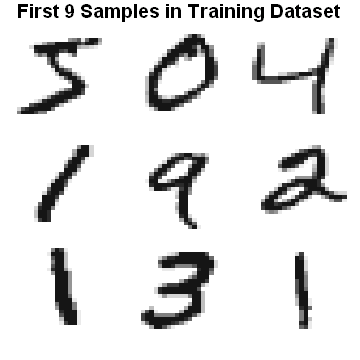

In [225]:
# Display first 9 images
library(repr)
options(repr.plot.width=3,repr.plot.height=3)
par(mfrow=c(3,3),mai=c(0,0,0,0),oma=c(1,0,1,0),cex=0.8)
for(i in 1:9)
{
    show_digit(as.numeric(train[i,1:784]))    
}
title("First 9 Samples in Training Dataset", outer=TRUE)

In [115]:
# Convert files to xdf
data.path <- "../"
trainXdf <- file.path(data.path, "train.xdf")
testXdf <- file.path(data.path, "test.xdf")
rxImport(inData=train, outFile = trainXdf, overwrite=TRUE)
rxImport(inData=test, outFile = testXdf, overwrite=TRUE)

Rows Read: 60000, Total Rows Processed: 60000, Total Chunk Time: 1.558 seconds 
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.328 seconds 


In [167]:
# Run clustering algorithm with random initialization
infile <- file.path(data.path, "train.xdf") 
trainXdf <- RxXdfData(file = infile)
trainClustersNoCenterXdf <- file.path(output.path, "trainClustersNoCenter.xdf")
vars <- rxGetVarNames(trainXdf)
vars <- vars[!vars  %in% c("y")]
formula <- as.formula(paste("~", paste(vars, collapse = "+")))
trainClustersNoCenter <- rxKmeans(formula = formula, 
                          data = trainXdf, numClusters = 10, outColName = 'predClusterNoCenter',
                          outFile = trainClustersNoCenterXdf, writeModelVars = TRUE,
                          extraVarsToWrite = "randSamp", maxIterations = 100000, 
                          overwrite = TRUE, reportProgress = 0
                          )

In [194]:
# Obtain cluster numbers
trainClustersNoCenterDF <- rxXdfToDataFrame(file = trainClustersNoCenterXdf,varsToKeep = 'predClusterNoCenter')
train$pred1 <- trainClustersNoCenterDF$predClusterNoCenter

Rows Processed: 60000
Time to read data file: 0.01 secs.
Time to convert to data frame: less than .001 secs.


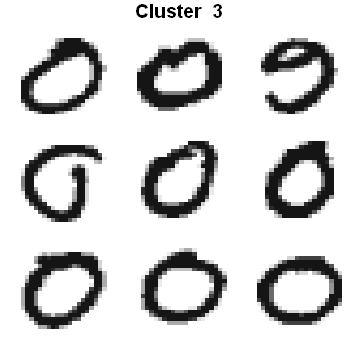

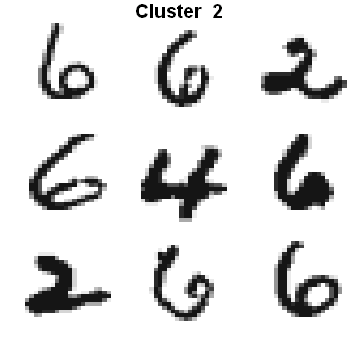

In [293]:
# Plot clusters
options(repr.plot.width=3,repr.plot.height=3)
c = 3
{
    par(mfrow=c(3,3),mai=c(0,0,0,0),oma=c(1,0,1,0),cex=0.8)
    indeces <- which(train$pred1==c)[60:68]
    for(i in indeces)
    {
        show_digit(as.numeric(train[i,1:784]))    
    }
    title(paste("Cluster ",c), outer=TRUE)
}
c = 2
{
    par(mfrow=c(3,3),mai=c(0,0,0,0),oma=c(1,0,1,0),cex=0.8)
    indeces <- which(train$pred1==c)[60:68]
    for(i in indeces)
    {
        show_digit(as.numeric(train[i,1:784]))    
    }
    title(paste("Cluster ",c), outer=TRUE)
}

In [278]:
# Run clustering algorithm with defined centers
vec = c()
for (c in 0:9)
{
    indeces <- which(train$y==c)[1:10]
    s <- as.numeric(colSums(train[indeces,1:784]))/10
    vec <- c(vec,s)
}
centers = t(matrix(vec,nrow=784,ncol=10))
trainClustersCenterXdf <- file.path(output.path, "trainClustersCenter.xdf")
trainClustersCenter <- rxKmeans(formula = formula, 
                          data = trainXdf, outColName = 'predClusterCenter',
                          outFile = trainClustersCenterXdf, writeModelVars = TRUE,
                          extraVarsToWrite = "randSamp", maxIterations = 100000, centers = centers,
                          overwrite = TRUE, reportProgress = 0
                          )

In [279]:
# Obtain cluster numbers
trainClustersCenterDF <- rxXdfToDataFrame(file = trainClustersCenterXdf,varsToKeep = 'predClusterCenter')
train$pred2 <- trainClustersCenterDF$predClusterCenter

Rows Processed: 60000
Time to read data file: 0.01 secs.
Time to convert to data frame: less than .001 secs.


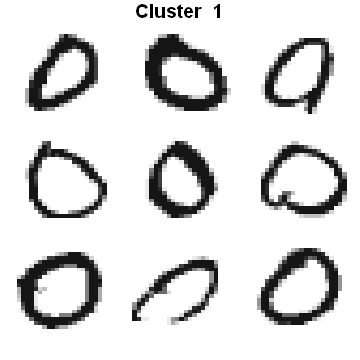

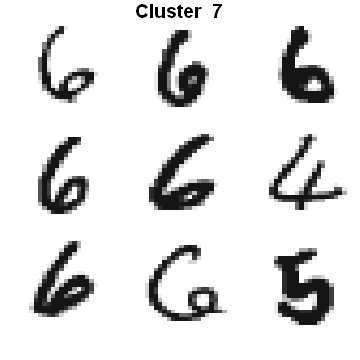

In [294]:
# Plot clusters
options(repr.plot.width=3,repr.plot.height=3)
c = 1
{
    par(mfrow=c(3,3),mai=c(0,0,0,0),oma=c(1,0,1,0),cex=0.8)
    indeces <- which(train$pred2==c)[60:68]
    for(i in indeces)
    {
        show_digit(as.numeric(train[i,1:784]))    
    }
    title(paste("Cluster ",c), outer=TRUE)
}
c = 7
{
    par(mfrow=c(3,3),mai=c(0,0,0,0),oma=c(1,0,1,0),cex=0.8)
    indeces <- which(train$pred2==c)[60:68]
    for(i in indeces)
    {
        show_digit(as.numeric(train[i,1:784]))    
    }
    title(paste("Cluster ",c), outer=TRUE)
}

In [314]:
# Calculate accuracy
accuracy <- as.data.frame.matrix(table(train$y,train$pred1))
accuracy[, "Total Number of Samples"] <- apply(accuracy[, 1:10], 1, sum)
accuracy[, "Accuracy Based on Random Centers"] <- apply(accuracy[, 1:10], 1, max)
randomCenterCorrect = sum(accuracy[, "Accuracy Based on Random Centers"])
totalSample = sum(accuracy[, "Total Number of Samples"])
accuracy[, "Accuracy Based on Random Centers"] <- 
        accuracy[, "Accuracy Based on Random Centers"]/accuracy[, "Total Number of Samples"]

temp <- as.data.frame.matrix(table(train$y,train$pred2))
accuracy[, "Accuracy Based on Labeled Samples"] <- apply(temp[, 1:10], 1, max)
labelCenterCorrect = sum(accuracy[, "Accuracy Based on Labeled Samples"])
accuracy[, "Accuracy Based on Labeled Samples"] <- 
        accuracy[, "Accuracy Based on Labeled Samples"]/accuracy[, "Total Number of Samples"]
accuracy <- accuracy[-c(1:10)]
cat("Overall Accuracy When Kmeans Initialized by Random Centers: ", randomCenterCorrect/totalSample,"\n")
cat("Overall Accuracy When Kmeans Initialized by Label-Based Centers: ", labelCenterCorrect/totalSample)
accuracy

Overall Accuracy When Kmeans Initialized by Random Centers:  0.59475 
Overall Accuracy When Kmeans Initialized by Label-Based Centers:  0.6368833

,Total Number of Samples,Accuracy Based on Random Centers,Accuracy Based on Labeled Samples
0,5923,0.4541617,0.7040351
1,6742,0.9811629,0.9829427
2,5958,0.7059416,0.6968781
3,6131,0.6504649,0.6396999
4,5842,0.5285861,0.4856214
5,5421,0.3327799,0.3349935
6,5918,0.5287259,0.6840149
7,6265,0.590423,0.6778931
8,5851,0.5940865,0.5961374
9,5949,0.5026055,0.4884855
